In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

In [2]:
#Calibrating the Camera

#filenames of all calibration images
files = glob.glob('./camera_cal/calibration*.jpg')

chessshape = (9,6)
objpoints = [] # Real world coordinates in 3D
imgpoints = [] # 2D points in image plane

cal_images = [] # all images of calibration

# setup object points consant for each calibration image
objp = np.zeros((chessshape[0]*chessshape[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessshape[0],0:chessshape[1]].T.reshape(-1,2)

# iterate through all images
for fname in files:
    # read image
    image = cv2.imread(fname)
    cal_images.append(np.copy(image))
    # convert to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # find chesscorners
    ret, corners = cv2.findChessboardCorners(gray, chessshape, None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(image, chessshape, corners, ret)

# Actual calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Undistorts the image by applying the camera calibration
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

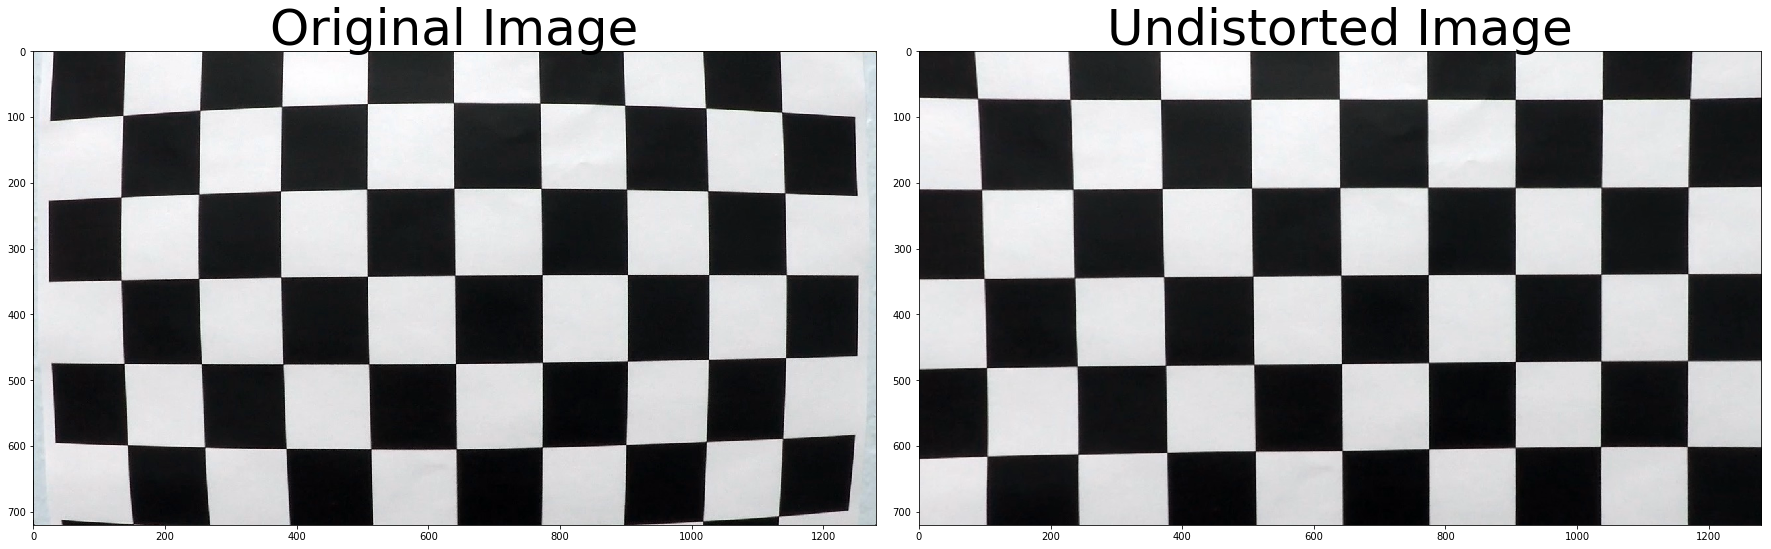

In [9]:
# test calibration on chessboard

# test calibration image
test_cal_image = cv2.imread('./camera_cal/calibration1.jpg')

dst = cv2.undistort(test_cal_image, mtx, dist, None, mtx)

# Plot calibration result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#cv2.imwrite('./output_images/camera_calibration.jpg',dst)
plt.savefig('./output_images/camera_calibration.jpg')




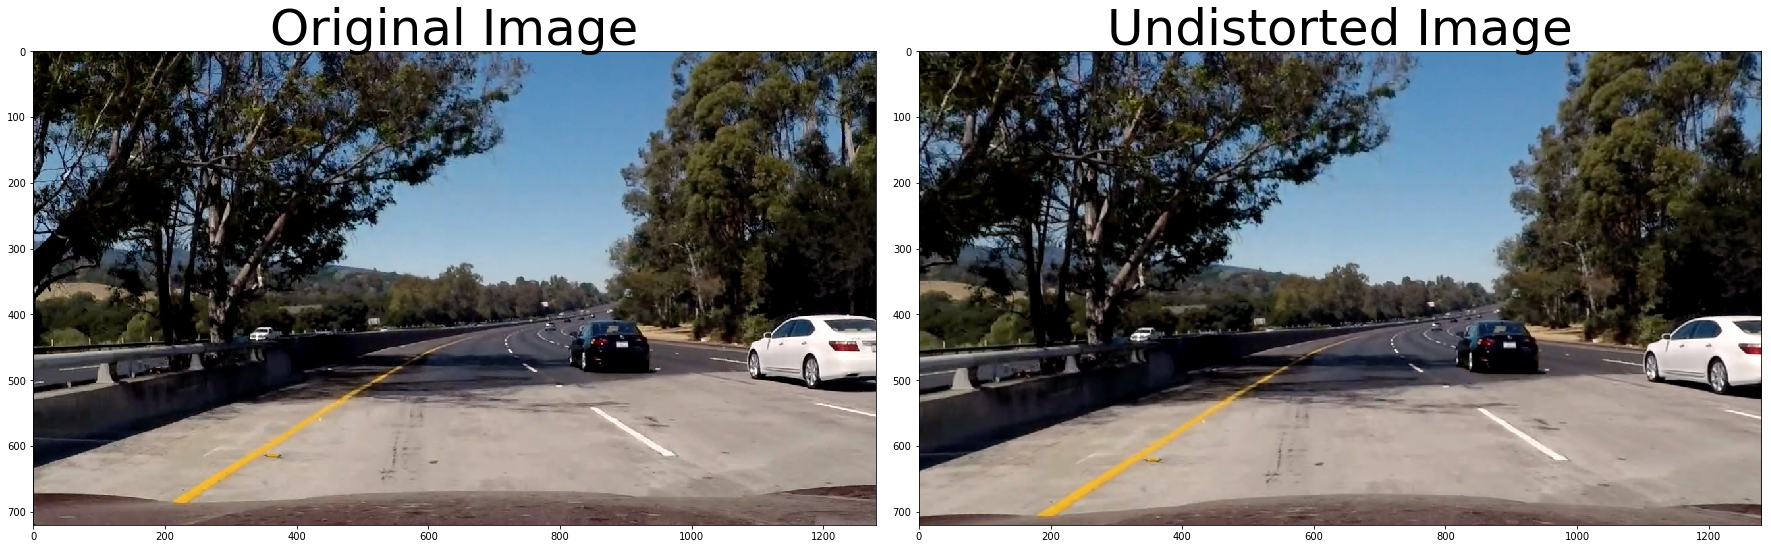

In [10]:
 # test calibration on image of road


# test images
test_files = glob.glob('./test_images/*.jpg')
test_files.sort()
test_images = []
# read an undistort all test images and save them to [test_images]
for test_file in test_files:
    test_image = cv2.imread(test_file)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_image = cv2.undistort(test_image, mtx, dist, None, mtx)
    test_images.append(test_image)

# test image
test_image = cv2.imread('./test_images/test5.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
dst = cv2.undistort(test_image, mtx, dist, None, mtx)


# Plot calibration result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('./output_images/calibration_real_world.jpg')



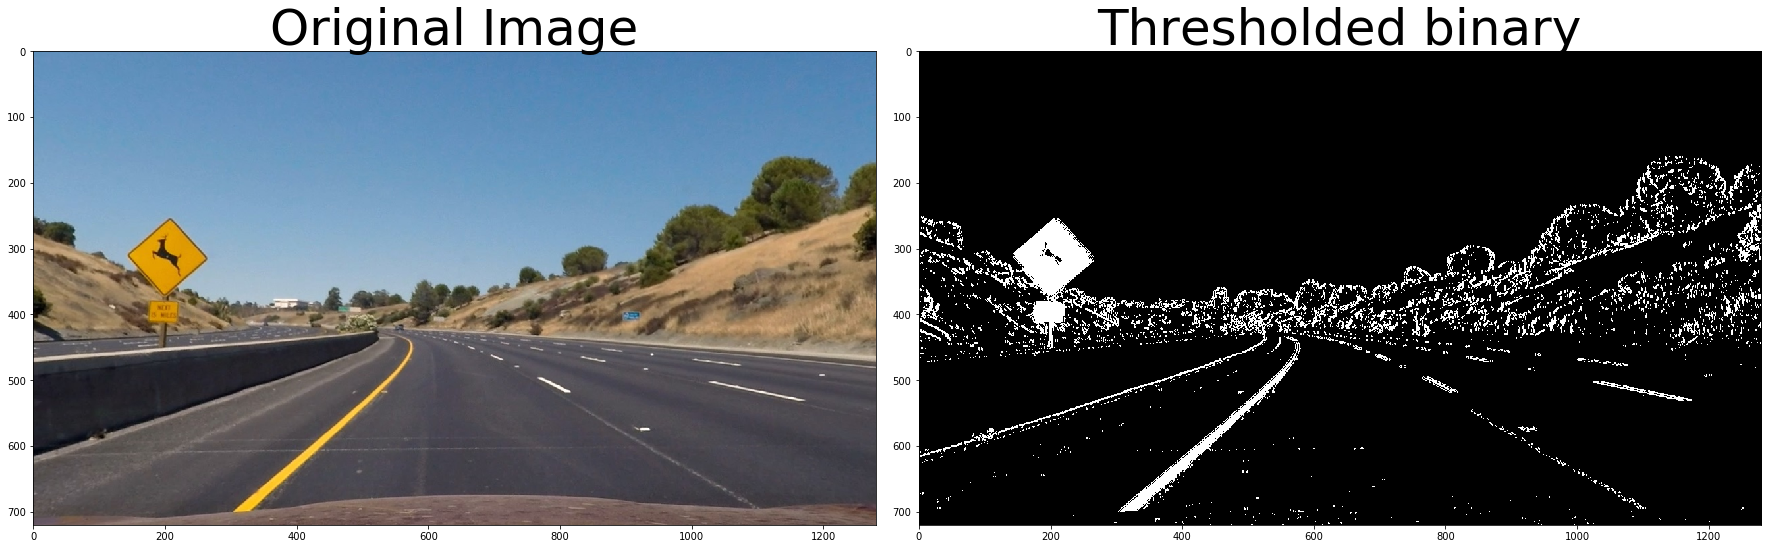

In [16]:
# show image
def show(img):
    plt.figure()
    plt.imshow(img, cmap='gray')

# Converts image to gray image
def cvtGray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Applies thresholds to image
def threshold(img, thresh=(0, 255)):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

# Scales the image to use full spectrum from 255
def scale(img): 
    return np.uint8(255*img/np.max(img))

# combines to images with 'and' or 'or' operator
def combine(img, operator, img2):
    binary_output = np.zeros_like(img)
    if(operator == 'and'):
        binary_output[(img == 1) & (img2 == 1)] = 1
    elif(operator == 'or'):
        binary_output[(img == 1) | (img2 == 1)] = 1
    return binary_output

# returns potential lane pixels
def potLanePixel(img):
    gray = cvtGray(img)
    # gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # absolute value of the x
    abs_sobelx = np.abs(sobelx)
    
    # Scales the image to use available range
    scaled_sobelx = scale(abs_sobelx)

    # threshholding sobel filter
    bin_sobelx = threshold(scaled_sobelx, thresh=(20,100))

    # Using hls color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    # threshholding color space
    sat = threshold(S, thresh=(170,255))
    
    # combining saturation and x gradient with an or operator
    result = combine(sat,'or', bin_sobelx)


    return result

# test image
org_img = test_images[3]
thresh_bin = potLanePixel(test_images[3])

# Plot result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(org_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresh_bin, cmap='gray')
ax2.set_title('Thresholded binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('./output_images/thresholded_binary.jpg')




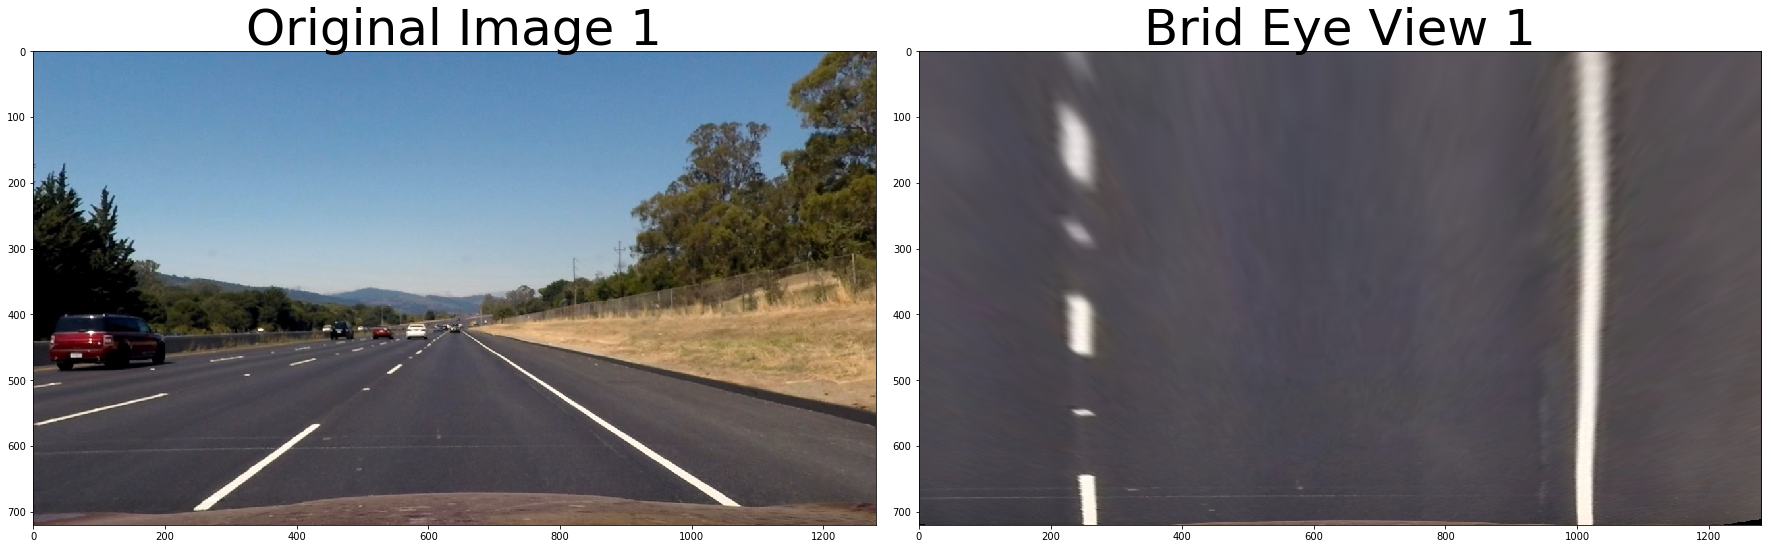

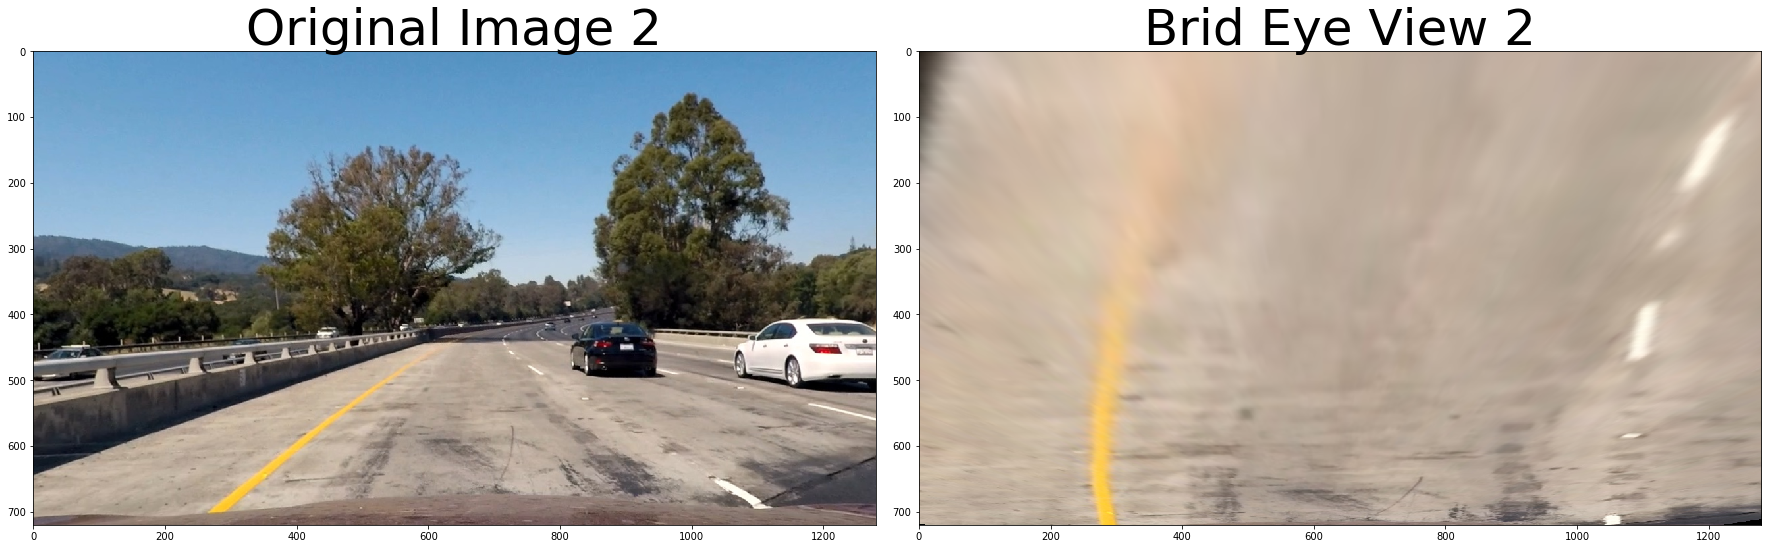

In [17]:
# transform perspective to birdseye

# approximated from an image with straight lane lines
src = np.float32([[250,690],[1050,690],[597,450],[686,450]])
dst = np.float32([[250,720],[1000,720],[250,0],[1000,0]])

M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)


# warps the dashcam view into birdview
def warp(img):
    return cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
# unwarps the bird view back to dashcam view
def unwarp(img):
    return cv2.warpPerspective(img, M_inv, img.shape[1::-1], flags=cv2.INTER_LINEAR)



perspective_test_1 = test_images[1]
perspective_test_1_bird_eye = warp(perspective_test_1)


perspective_test_2 = test_images[2]
perspective_test_2_bird_eye = warp(perspective_test_2)


# Plot result test 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(perspective_test_1)
ax1.set_title('Original Image 1', fontsize=50)
ax2.imshow(perspective_test_1_bird_eye, cmap='gray')
ax2.set_title('Brid Eye View 1', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('./output_images/birds_eye_test_1.jpg')

# Plot result test 2
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(perspective_test_2)
ax1.set_title('Original Image 2', fontsize=50)
ax2.imshow(perspective_test_2_bird_eye, cmap='gray')
ax2.set_title('Brid Eye View 2', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('./output_images/birds_eye_test2.jpg')

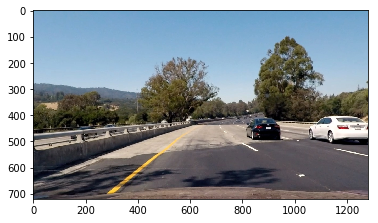

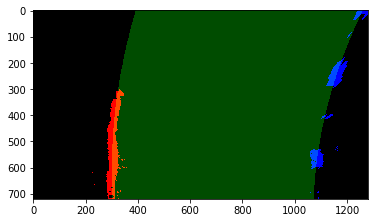

In [20]:
# identify lines out of potential lane line pixels

# finds the the origin position of both lines by using an historgram
def base_points(img):
    # clip bottom half of image
    bottom_half = img[img.shape[0]//2:,:]
    # create a histogramm showing the occurence of white pixel appearing along the x axis
    histogram = np.sum(bottom_half, axis=0)
    # calc midpoint of image
    midpoint = img.shape[1]//2
    # return the maximum of the left and the right half of the image, respectively
    return np.argmax(histogram[:midpoint]), np.argmax(histogram[midpoint:]) + midpoint


# Finds all lane pixels with a sliding window
def find_start_lane_pixels(warp_bin):
    # returns start position (origin) of lanes
    leftx_base, rightx_base = base_points(warp_bin)

    # number of windows to divide the image into
    n_win = 9

    # margin of the search window
    margin = 80

    # minimum number of pixels needed to rebase the next window
    minpix = 50

    # height of a search window
    window_height = np.int(image.shape[0]//n_win)

    # get all nonzero pixels
    nonzero = warp_bin.nonzero()
    # y index of nonzero pixels
    nonzeroy = np.array(nonzero[0])
    # x index of nonzero pixels
    nonzerox = np.array(nonzero[1])

    # current lane x coordinate to start coordinate
    leftx_current = leftx_base
    rightx_current = rightx_base

    # start with empty lane lines
    left_lane_inds = []
    right_lane_inds = []

    # sliding window: for each window detect lane lines
    for window in range(n_win):
        # y bound of window
        win_y_low = warp_bin.shape[0] - (window+1) * window_height
        win_y_high = warp_bin.shape[0] - window * window_height

        # x bound of window for left lane
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        # x bound of window for right lane
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # assign any nonzero pixels within the window to the lane lines
        left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # append already found lane line indices with the one just identified
        left_lane_inds.append(left_inds)
        right_lane_inds.append(right_inds)

        # check if the threshold minpix has been reached fo any of the lane line
        # if more than minpix have been found in the current window the next window will be recentered
        # to the average x which has been found
        if len(left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[left_inds]))
        if len(right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[right_inds]))
    
    # make one long list out of the list of lists containing the lane line indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # return the x and y coordinate for each lane line, respectively
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

# fit polynomial to binary thresholded image
def fitPolynomial(warp_bin):
    # find all lane line pixels
    leftx, lefty, rightx, righty = find_start_lane_pixels(warp_bin)

    # fit polynomial into the found lane line pixels
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(warp_bin.shape, leftx, lefty, rightx, righty)

    return lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx, left_fit, right_fit

# fit polynomial to left and right lane pixels
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # calc coefficients of polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # create evenly spaced y coordinates
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    # calculate pixels of the fitted polynomial
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # return all parameters
    return left_fitx, right_fitx, ploty, left_fit, right_fit

# Visualizes the lane line
def visualizeLines(warp_bin, lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx):
    # make binary image colored
    out_img = np.dstack((warp_bin, warp_bin, warp_bin))*255
    lines_img = np.zeros_like(out_img)
    window_img = np.zeros_like(out_img)

    # color left lane in red
    lines_img[lefty, leftx] = [255, 0, 0]
    # color right lane in blue
    lines_img[righty, rightx] = [0, 0, 255]

    # color the lane between the polynomials of the left and right lane line green
    lane_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    lane_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_pts = np.hstack((lane_window1, lane_window2))
    cv2.fillPoly(window_img, np.int_([lane_pts]), (0,255, 0))
    result = cv2.addWeighted(lines_img, 1, window_img, 0.3, 0)

    # return the image overlay
    return result




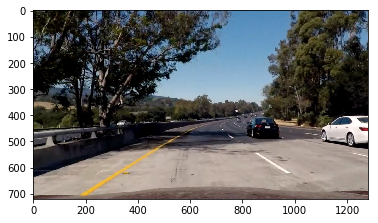

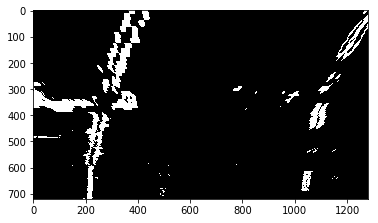

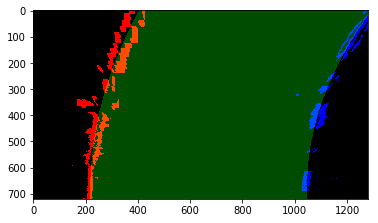

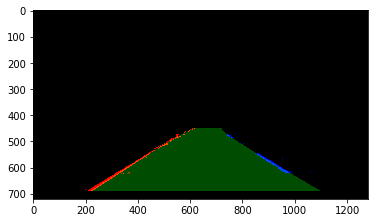

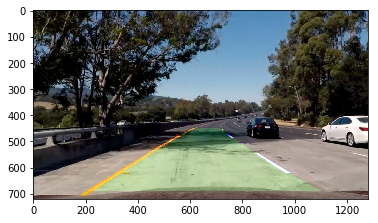

In [23]:
image = test_images[6]
show(image)
warp_bin = warp(potLanePixel(image))

show(warp_bin)

lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx, left_fit, right_fit = fitPolynomial(warp_bin)
poly_img = visualizeLines(warp_bin,lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx)

show(poly_img)


unwarped_vis = unwarp(poly_img)
show(unwarped_vis)

result = cv2.addWeighted(image, 1, unwarped_vis, 0.5, 0)
show(result)



In [39]:
# measures the curvature of the lane lines with their polynomial coefficients 
def measure_curvature_real(y_eval, left_fit_cr, right_fit_cr):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_curverad = (1+(2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**(1.5) / np.abs(2*left_fit_cr[0])
    right_curverad = (1+(2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**(1.5) / np.abs(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

# calculates the offset of the car in regards to the lane center
# if the offset <0 the car is to the left of lane center and >0 the car is to right of lane center
def offset_from_center(car_center, leftx, rightx):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    lane_center = (rightx-leftx)//2 + leftx
    px_offset = lane_center - car_center
    return xm_per_pix * px_offset 

def offsetToString(offset):
    if(offset < 0):
        return str(np.abs(offset)) + 'm left of center'
    else:
        return str(np.abs(offset)) + 'm right of center'

left_curverad, right_curverad = measure_curvature_real(img.shape[0], left_fit, right_fit)

print(left_curverad, 'm', right_curverad, 'm')

1809.09543602 m 1669.78155251 m


In [40]:
# Define a class to receive the characteristics of each line detection
# provided by udacity
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

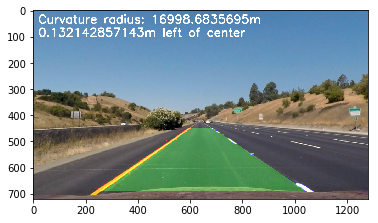

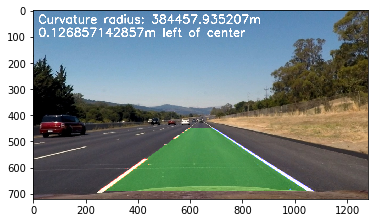

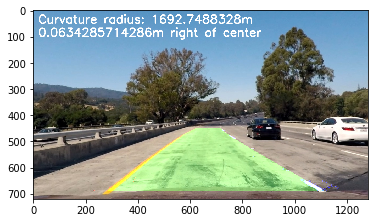

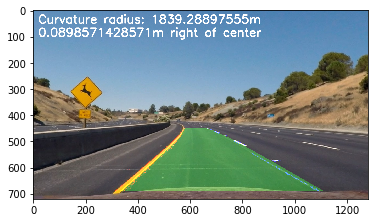

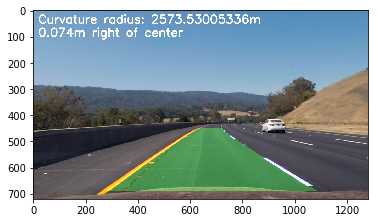

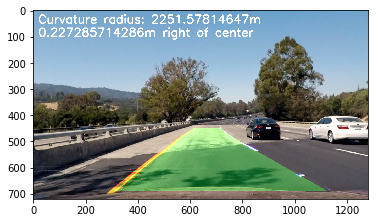

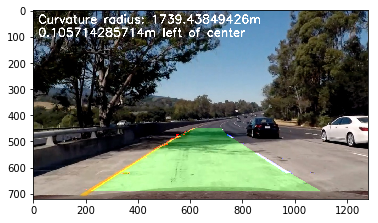

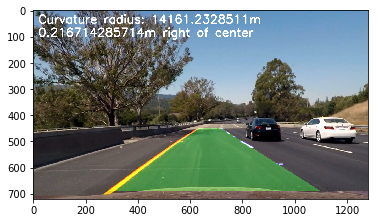

In [42]:
right_line = Line()
left_line = Line()
# processing the image and returning the image with an overlay of the detected lane
def pipeline(img, left_line, right_line):
    warp_bin = warp(potLanePixel(img))
    lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx, left_fit, right_fit = fitPolynomial(warp_bin)
    poly_img = visualizeLines(warp_bin,lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx)
    left_curverad, right_curverad = measure_curvature_real(poly_img.shape[0], left_fit, right_fit)
    curvature = (left_curverad + right_curverad)/2
    offset = offset_from_center(img.shape[1]//2,leftx[0], rightx[0])
    unwarped_vis = unwarp(poly_img)
    result = cv2.addWeighted(img, 1, unwarped_vis, 1, 0)
    result = cv2.putText(result,'Curvature radius: ' + str(curvature) + 'm',(20,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),3,cv2.LINE_AA)
    result = cv2.putText(result,offsetToString(offset),(20,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),3,cv2.LINE_AA)
    return result, left_line, right_line

for i in test_images:
    img,_,_ = pipeline(i, Line(),Line())
    show(img)

In [44]:
# libs for videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0303104/28549024 bytes (1.11433600/28549024 bytes (5.0%2981888/28549024 bytes (10.44546560/28549024 bytes (15.96053888/28549024 bytes (21.27684096/28549024 bytes (26.99256960/28549024 bytes (32.410821632/28549024 bytes (37.9%12394496/28549024 bytes (43.4%13967360/28549024 bytes (48.9%15523840/28549024 bytes (54.4%17088512/28549024 bytes (59.9%18653184/28549024 bytes (65.3%20217856/28549024 bytes (70.8%21749760/28549024 bytes (76.2%23363584/28549024 bytes (81.8%24928256/28549024 bytes (87.3%26509312/28549024 bytes (92.9%28049408/28549024 bytes (98.2%28549024/28549024 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg.linux64.


In [43]:
# processes a single image part of a series of images
def process_image(image):
    global left_line
    global right_line
    result, left_line, right_line = pipeline(image, left_line, right_line)
    return result

In [ ]:
project_output = 'project_video_output.mp4'

# reset lines
left_line = Line()
right_line = Line()

# process video and detect lane
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_output, audio=False)

In [ ]:
# show video
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))